# 시계열 분석 기말 과제 12월 14일까지 제출
> 기말 과제

- toc:true
- branch: master
- badges: true
- comments: false
- author: 최서연
- categories: [timeseries]

#### 1. 사용할 데이터 : mcopper

##### (4) (2),(3)번 모형 중 어떤 모형일 더 적절한지 설명하여라.
##### (5) (4)에서 선택한 모형을 이용하여 잔차검정을 시행하여라.
##### (6) 2007년과 2008년 데이터를 예측하여라

In [52]:
#collapse
library(fpp2)
library(astsa)
library(data.table)
library(ggplot2) 
library(gridExtra)
library(forecast)
library(portes) 
library(fUnitRoots) 
library(tseries) 
library(sarima)
library(lmtest)

##### (1) 변수변환이 필요한지를 설명하고, 필요하다면 적절한 변수 변환을 하여라.

In [22]:
#collapse
z <- as.numeric(mcopper)

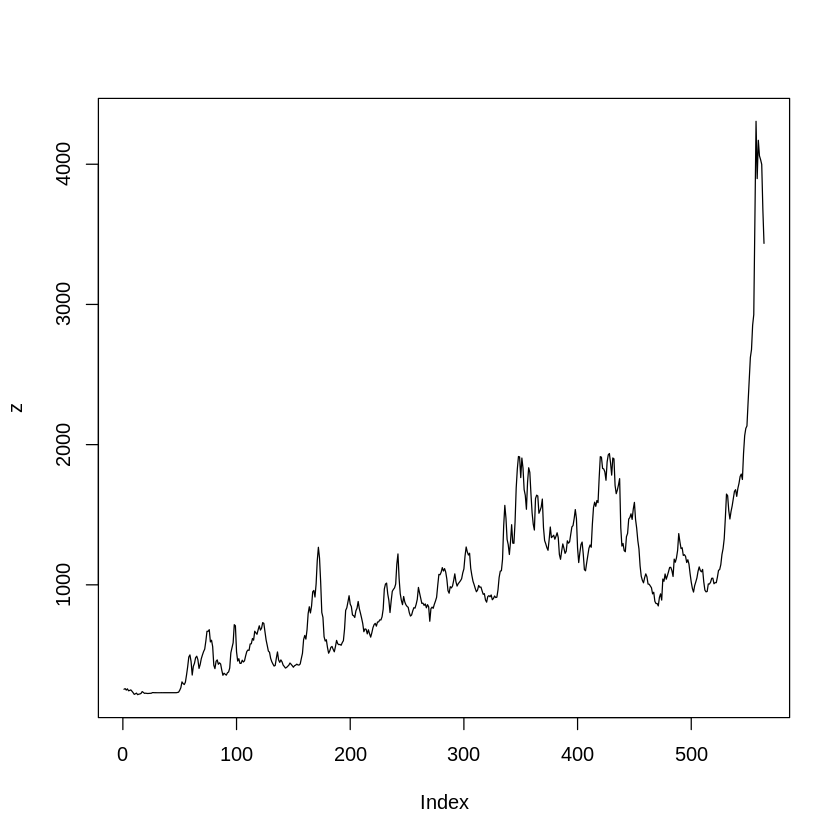

In [23]:
#collapse
plot(z, type='l')

- 등분산을 이루지 않고 있는 모습을 보인다.

```R
BoxCox.lambda(z, method='loglik')
```
```
0.25
```
- 분산안정화시켜주는 람다값은 0.25가 나왔다.

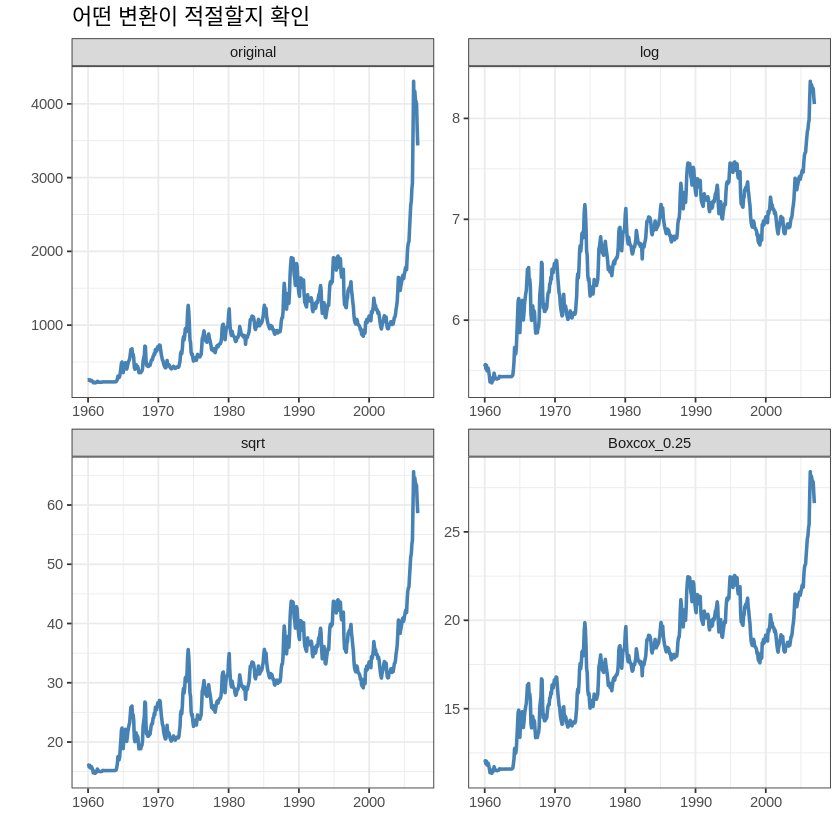

In [24]:
#collapse
tmp.dat <- data.table(
  t=seq.Date(as.Date("1960-01-01"), 
             by='month', 
             length.out=564),
  original=z,
  log = log(z),
  sqrt = sqrt(z),
  Boxcox_0.25 = BoxCox(z,lambda= BoxCox.lambda(z, method='loglik')) 
)
melt.tmp <- melt(tmp.dat, id=1)
ggplot(melt.tmp, aes(t,value)) + 
  geom_line(col='steelblue', lwd=1) +
  xlab("")+ylab("")+
  ggtitle("어떤 변환이 적절할지 확인")+
  theme_bw()+
  facet_wrap(.~variable, nrow = 2, scales = "free")

In [25]:
tmp.dat[, lnz:= log(z)]

- 시계열 그림을 그려보니 마지막이 독특하게 튀어나온 모습을 볼 수 있었고, 분산 안정화를 통해 정상화가 필요하겠다.
- 그림을 그려보니 trend는 모두 비슷하지만 log 변환이 가장 분산이 안정화되어 보인다.
- 그래서 log 변환을 적용했다.

##### (2) auto.arima 를 이용하여 예측 모형을 적합하여라. (형태 : ARIMA(p.d.q)(P,D,Q)s , 모수 추정값)

In [26]:
auto.arima(tmp.dat$lnz)
auto.arima(tmp.dat$lnz, trace=T, ic='aic')

Series: tmp.dat$lnz 
ARIMA(0,1,1) 

Coefficients:
         ma1
      0.3756
s.e.  0.0385

sigma^2 estimated as 0.003634:  log likelihood=782.84
AIC=-1561.69   AICc=-1561.66   BIC=-1553.02


 Fitting models using approximations to speed things up...

 ARIMA(2,1,2) with drift         : -1555.199
 ARIMA(0,1,0) with drift         : -1485.363
 ARIMA(1,1,0) with drift         : -1543.596
 ARIMA(0,1,1) with drift         : -1556.04
 ARIMA(0,1,0)                    : -1484.453
 ARIMA(1,1,1) with drift         : -1553.325
 ARIMA(0,1,2) with drift         : -1554.063
 ARIMA(1,1,2) with drift         : Inf
 ARIMA(0,1,1)                    : -1556.275
 ARIMA(1,1,1)                    : -1553.645
 ARIMA(0,1,2)                    : -1554.28
 ARIMA(1,1,0)                    : -1544.171
 ARIMA(1,1,2)                    : -1555.619

 Now re-fitting the best model(s) without approximations...

 ARIMA(0,1,1)                    : -1561.685

 Best model: ARIMA(0,1,1)                    



Series: tmp.dat$lnz 
ARIMA(0,1,1) 

Coefficients:
         ma1
      0.3756
s.e.  0.0385

sigma^2 estimated as 0.003634:  log likelihood=782.84
AIC=-1561.69   AICc=-1561.66   BIC=-1553.02

- auto.arima를 적용해보았다.
- ARIMA(0,1,1) 모형, 즉 한 번 차분한 MA(1) 모형이 제일 적합하다는 결론이 나왔다.

In [39]:
fit = arima(tmp.dat$lnz, order = c(0,1,1), , seasonal = list(order = c(0,0,0), period = 0))
fit


Call:
arima(x = tmp.dat$lnz, order = c(0, 1, 1), seasonal = list(order = c(0, 0, 0), 
    period = 0))

Coefficients:
         ma1
      0.3756
s.e.  0.0385

sigma^2 estimated as 0.003628:  log likelihood = 782.84,  aic = -1561.69

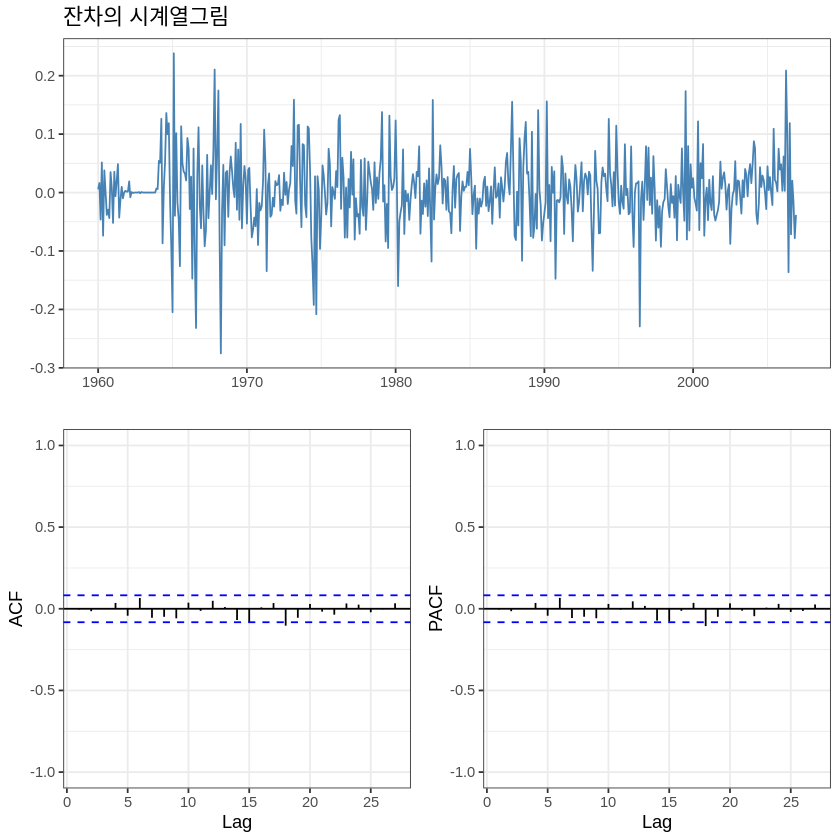

In [40]:
#collapse
tmp.dat[, res := as.numeric(resid(fit))]

p3 <- ggplot(tmp.dat, aes(t, res)) + 
  geom_line(col='steelblue') +
  xlab("")+ylab('')+ ggtitle('잔차의 시계열그림')+
  theme_bw()

p1 <- ggAcf(tmp.dat$res) + 
  theme_bw() + ylim(-1,1) +
  theme(plot.title = element_blank())

p2 <- ggPacf(tmp.dat$res) + 
  theme_bw() +ylim(-1,1) +
  theme(plot.title = element_blank())

grid.arrange(p3, p1, p2, nrow = 2,
             layout_matrix = rbind(c(1,1),
                                   c(2,3)))

,lags,statistic,df,p-value
,6,4.389073,5,0.49486084
,12,11.774747,11,0.38081082
,18,25.513977,17,0.08378234
,24,29.716259,23,0.15772145



	Shapiro-Wilk normality test

data:  tmp.dat$res
W = 0.96372, p-value = 1.406e-10


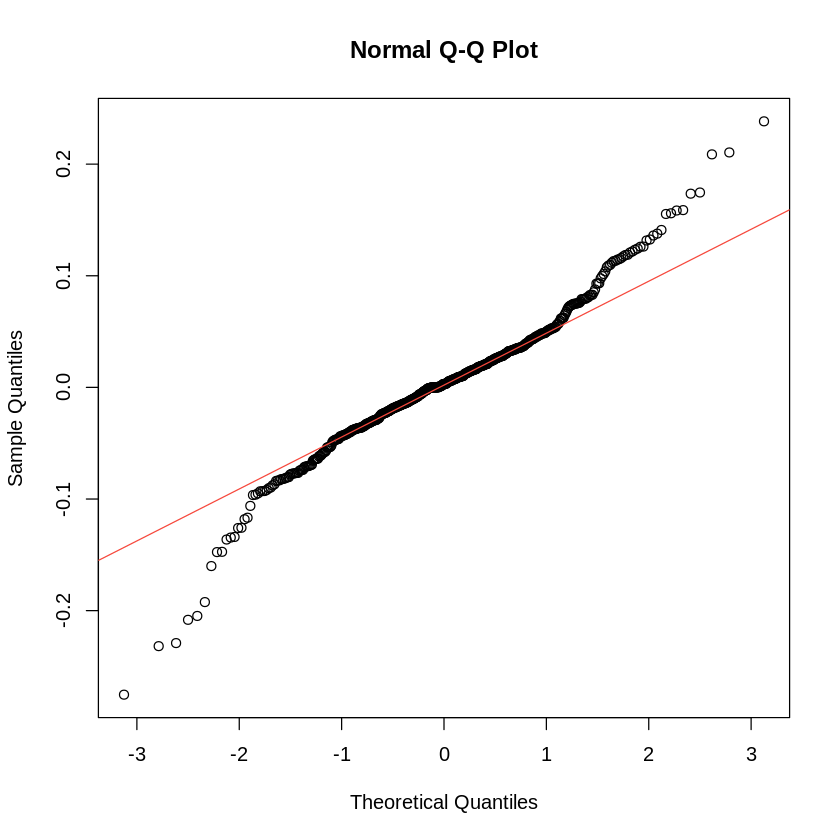

In [41]:
#collapse
LjungBox(fit, lags=seq(6,24,6))
shapiro.test(tmp.dat$res) 
qqnorm(tmp.dat$res)
qqline(tmp.dat$res, col = 2)

- 해당 모형에 적합한 후 잔차 그림을 그려보니 ACF,PACF에서 유의한 값을 찾을 수 없었고, 잔차그림도 잘 분산되어 있는 것 같다.
- 잔차의 포트맨토검정결과 모두 귀무가설을 기각하지 못해 모형 적합이 잘되었나 싶었지만, shapiro.test 결과 정규성가정을 만족하지 못했다.

##### (3) (2)번 모형을 제외한 다른 후보 모형을 선택하여 적합하여라. . (형태 : ARIMA(p.d.q)(P,D,Q)s , 모수 추정값)

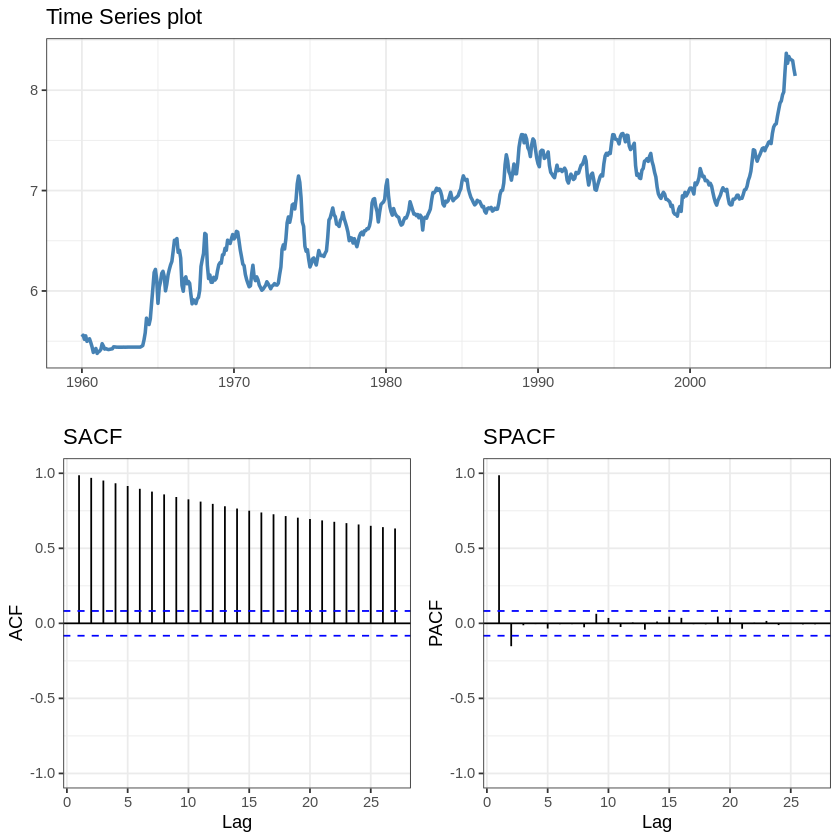

In [30]:
#collapse
p1 <- ggplot(tmp.dat, aes(t, lnz)) + 
  geom_line(col='steelblue', lwd=1) +
  xlab("")+ylab("")+
  ggtitle("Time Series plot")+
  theme_bw()
p2 <- ggAcf(tmp.dat$lnz) + 
  theme_bw() + ylim(-1,1) +
  ggtitle("SACF")

p3 <- ggPacf(tmp.dat$lnz) + 
  theme_bw() +ylim(-1,1) +
  ggtitle("SPACF")

grid.arrange(p1, p2, p3, nrow = 2,
             layout_matrix = rbind(c(1, 1),
                                   c(2, 3)))

- log 변환 후 plot을 그려보니 양의 상관관계가 있어보이긴 하나, 이분산성이 아직 존재하는 것처럼 보인다.
- ACF가 지수적으로 천천히 감소하는 모습을 보여 차분이 필요할 것 같다.
- PACF가 2까지 유의한 것을 보니 MA(2) 모형을 선택할 수도 있겠다.

In [45]:
tmp.dat[, diff_z := c(0, diff(lnz))]

- 차분하였다.

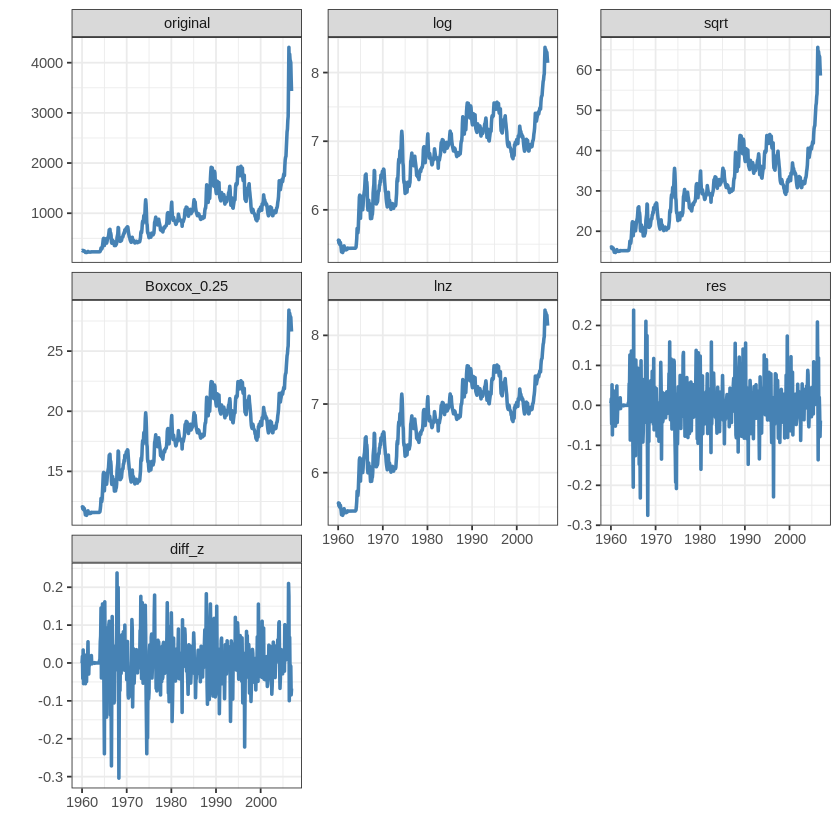

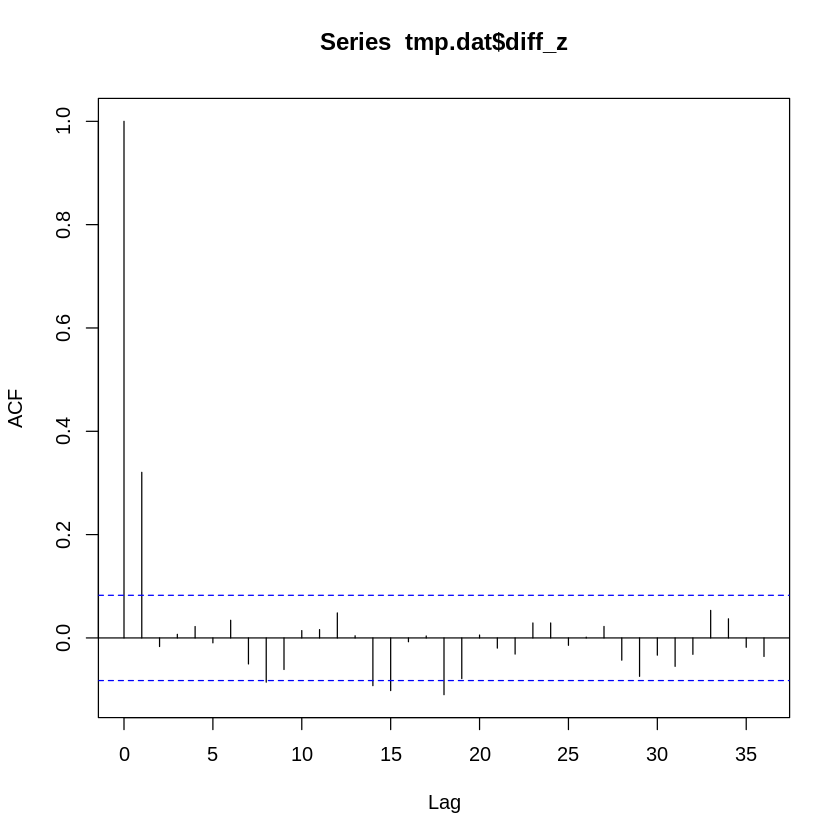

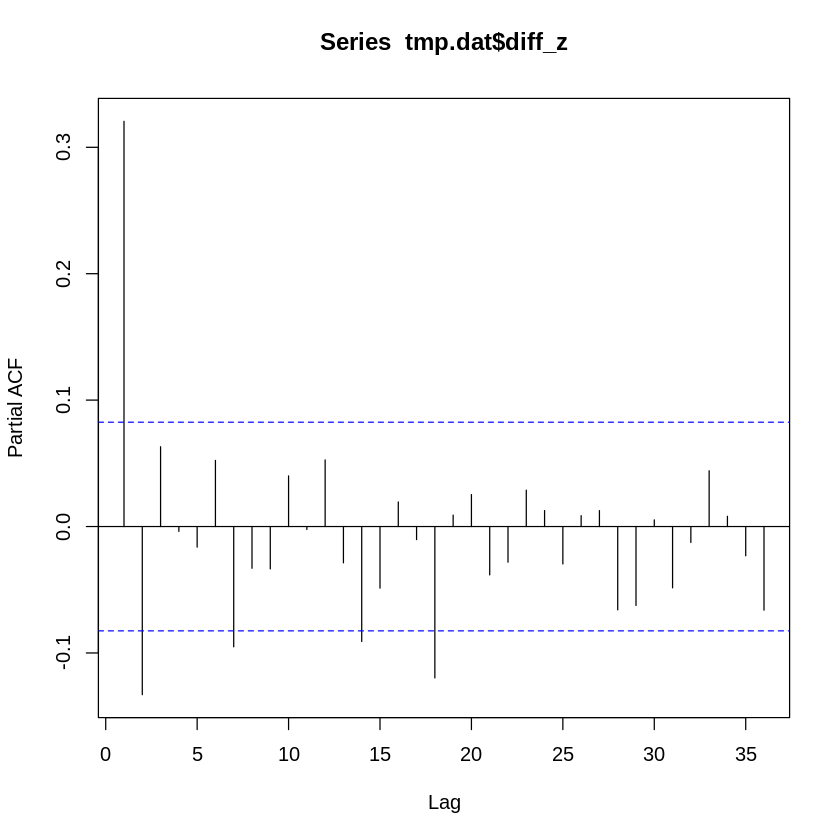

In [46]:
melt_dt <- melt(tmp.dat, id=1)

ggplot(melt_dt, aes(t, value)) + 
  geom_line(col='steelblue', lwd=1) +
  xlab("")+ylab("")+
  # ggtitle("Time Series plot : diff(Random Walk)")+
  # scale_x_continuous(breaks = seq(0,30, by = 6))+
  # geom_hline(yintercept = 0, lty=2, col='grey')+
  theme_bw()+
  facet_wrap(~variable, scales = 'free_y')

acf(tmp.dat$diff_z, lag.max = 36)
# 12차수에서만 유의하지 않음, 24,36에서도 유의
pacf(tmp.dat$diff_z, lag.max = 36)
# 12차수만 유의하고 뒤는 안 그래.

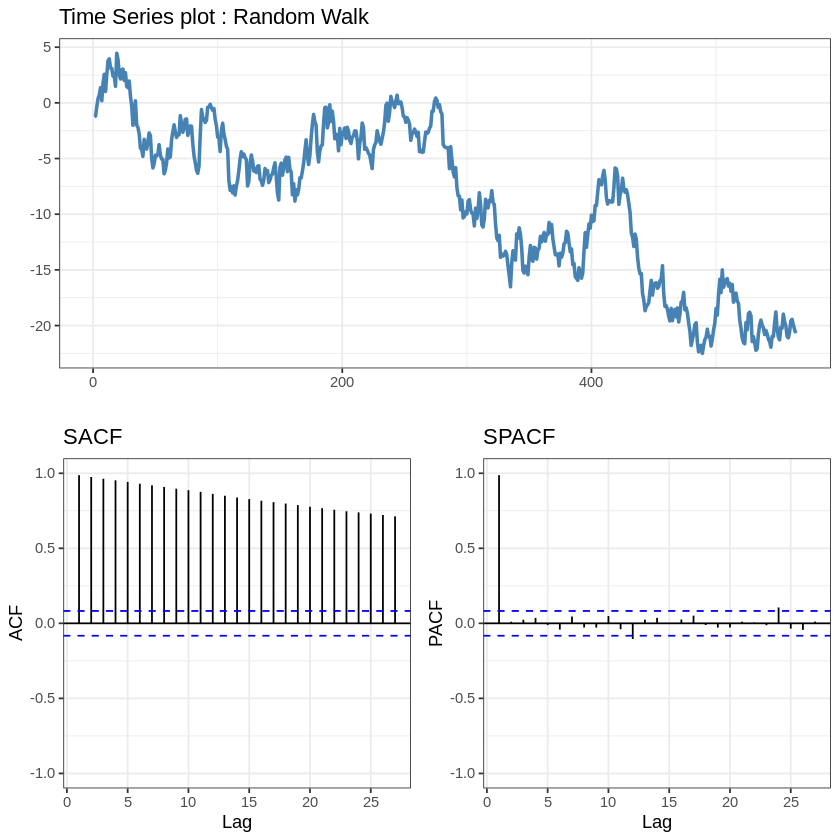

In [44]:
#collapse
e <- rnorm(564)

tmp.dat1 <- data.table(t=1:564, z=cumsum(e))
tmp.dat1[, dz := c(0, diff(z))]


p1 <- ggplot(tmp.dat1, aes(t, z)) + 
  geom_line(col='steelblue', lwd=1) +
  xlab("")+ylab("")+
  ggtitle("Time Series plot : Random Walk")+
  theme_bw()
p2 <- ggAcf(tmp.dat1$z) + 
  theme_bw() + ylim(-1,1) +
  ggtitle("SACF")

p3 <- ggPacf(tmp.dat1$z) + 
  theme_bw() +ylim(-1,1) +
  ggtitle("SPACF")

grid.arrange(p1, p2, p3, nrow = 2,
             layout_matrix = rbind(c(1, 1),
                                   c(2, 3)))

- 확률보행과정 정상화 후 그림을 그려보았다.
- SACF 가 천천히 지수적으로 감소하고 있는 것처럼 보인다. 따라서 차분이 필요하겠다.
- ACF 는 lag 1에서만 유의하게 나왔다.

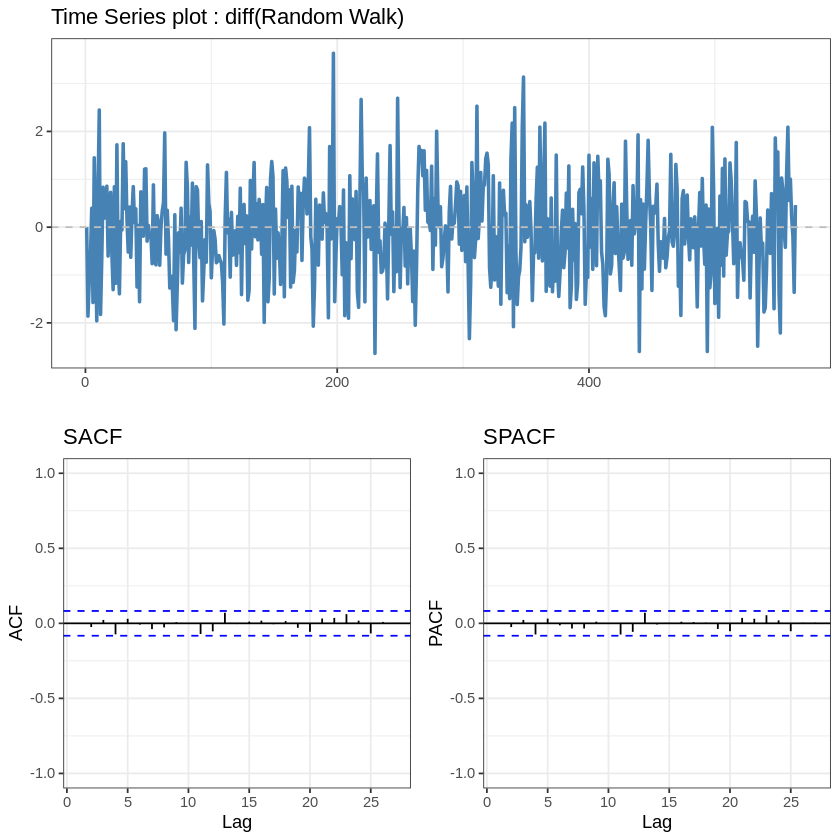

In [37]:
p1 <- ggplot(tmp.dat1, aes(t, dz)) + 
  geom_line(col='steelblue', lwd=1) +
  xlab("")+ylab("")+
  ggtitle("Time Series plot : diff(Random Walk)")+
  geom_hline(yintercept = 0, lty=2, col='grey')+
  theme_bw()

p2 <- ggAcf(tmp.dat1$dz) + 
  theme_bw() + ylim(-1,1) +
  ggtitle("SACF")

p3 <- ggPacf(tmp.dat1$dz) + 
  theme_bw() +ylim(-1,1) +
  ggtitle("SPACF")
grid.arrange(p1, p2, p3, nrow = 2,
             layout_matrix = rbind(c(1, 1),
                                   c(2, 3)))

- 차분한 확률보행과정의 plot을 그려보았다.
- ACF, PACF 모두 유의하지 않은, 백색소움 과정의 모습처럼 나온 것을 볼 수 있었다.

#### 2. 사용할 데이터 : hsales

##### (1) 변수변환이 필요한지를 설명하고 , 필요하다면 적절한 변수 변환을 하여라 

In [103]:
z<-as.numeric(hsales)
length(z)

[1] 275

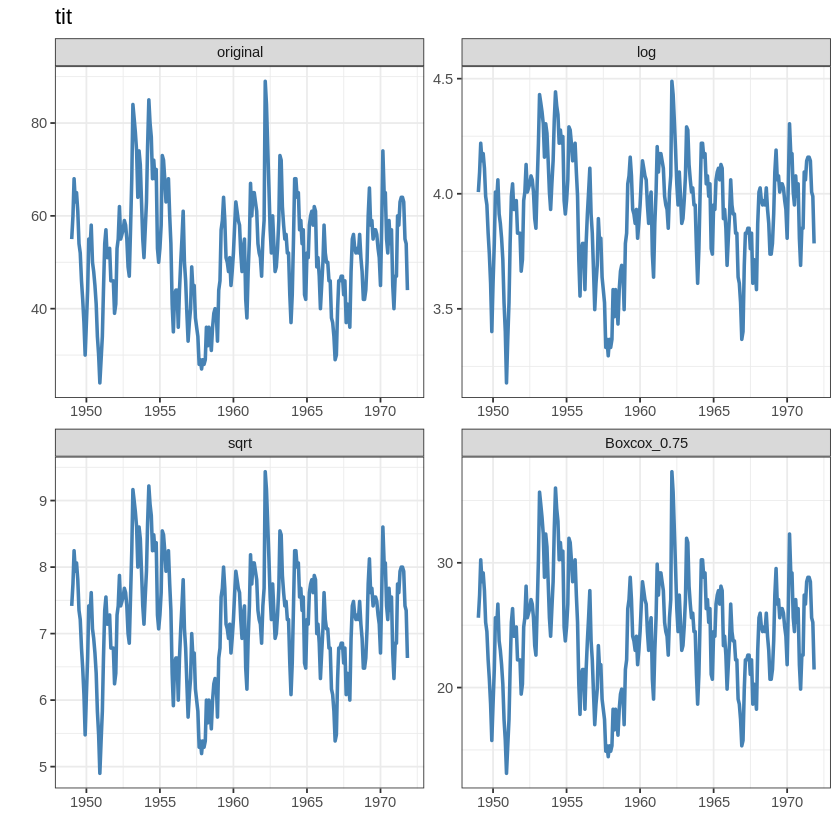

In [110]:

tmp.dat <- data.table(
  t=seq.Date(as.Date("1949-01-01"), 
             by='month', 
             length.out=275),
  original=z,
  log = log(z),
  sqrt = sqrt(z),
  Boxcox_0.75 = BoxCox(z,lambda= BoxCox.lambda(z, method='loglik')) 
)
melt.tmp <- melt(tmp.dat, id=1)
ggplot(melt.tmp, aes(t,value)) + 
  geom_line(col='steelblue', lwd=1) +
  xlab("")+ylab("")+
  ggtitle("tit")+
  theme_bw()+
  facet_wrap(.~variable, nrow = 2, scales = "free")



```python
BoxCox.lambda(z, method='loglik')
```
```
0.75
```

- 변수 변환은 필요 없어보인다.
- 추세가 존재하지도 않고 이분산성도 보이지 않기 때문이다.

##### (2) 데이터가 정상시계열인가 ? 아니면 적절한 차분을 통해 정상시계열로 변환하여라 .

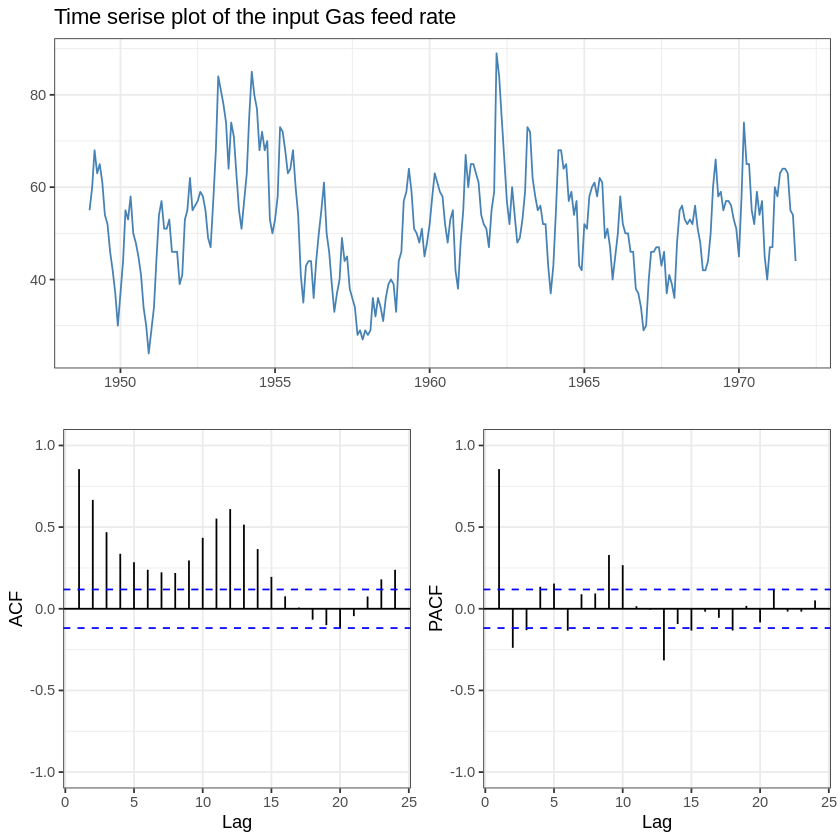

In [111]:
p3 <- ggplot(tmp.dat, aes(t, original)) +  geom_line(col='steelblue') +
  xlab("")+ylab('')+ ggtitle('Time serise plot of the input Gas feed rate')+
  theme_bw()

p1 <- ggAcf(tmp.dat$original) +  theme_bw() + ylim(-1,1) +
  theme(plot.title = element_blank())

p2 <- ggPacf(tmp.dat$original) + theme_bw() +ylim(-1,1) +
  theme(plot.title = element_blank())

grid.arrange(p3, p1, p2, nrow = 2,
             layout_matrix = rbind(c(1,1), c(2,3)))

- 추세가 없어보임, 평균이 60인 것 같다.
- ACF가 빠르게 감소하고 있는 것처럼 보이면서 산처럼 솟은 곳이 보여 계절차분을 해도 되겠다.
- PACF 1 이후 유의한 부분이 보인다. 아마 ACF에서 판단한 것처럼 계절차분이 필요하기 때문이지 않을까? 
- 혹은 ACF가 빠르게 감소한다고 보고, PACF를 1시차에서 절단된다고 봐서 MA(1) 모형을 적합해보는 방법도 고려해봤다.

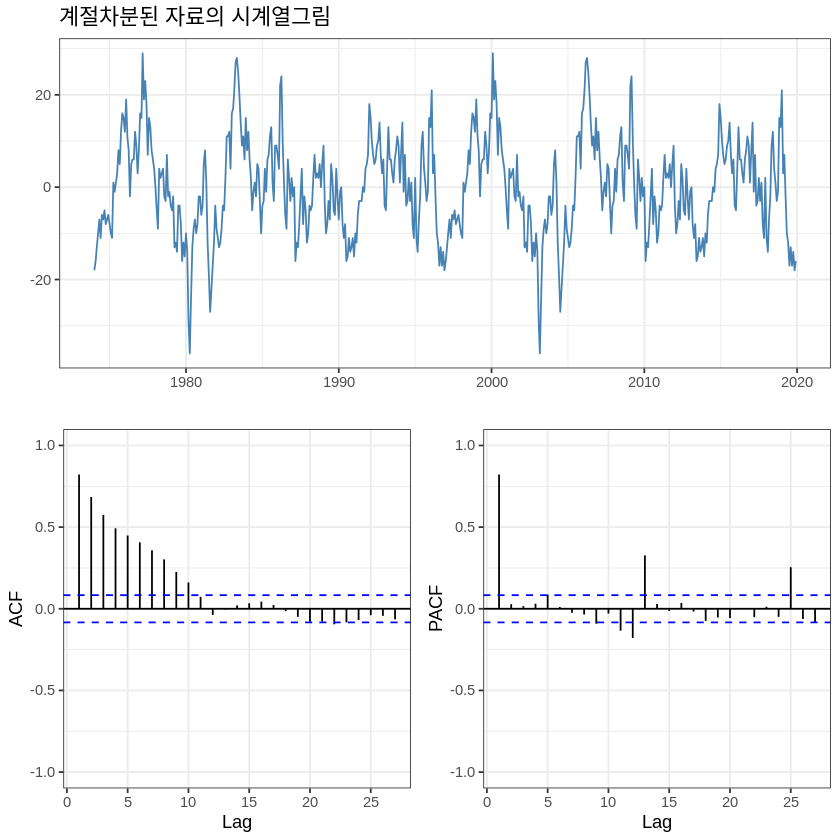

In [60]:
tmp.dat[, df1_z := c(rep(0,12), diff(original,12))]
sdt <- tmp.dat[-(1:12)]
p3 <- ggplot(sdt, aes(t, df1_z)) + geom_line(col='steelblue') +
  xlab("")+ylab('')+ ggtitle('계절차분된 자료의 시계열그림')+
  theme_bw()

p1 <- ggAcf(sdt$df1_z) + theme_bw() + ylim(-1,1) +
  theme(plot.title = element_blank())

p2 <- ggPacf(sdt$df1_z) + theme_bw() +ylim(-1,1) +
  theme(plot.title = element_blank())

grid.arrange(p3, p1, p2, nrow = 2,
             layout_matrix = rbind(c(1,1), c(2,3)))

- ACF가 빠르게 감소하고 있어 정상성을 띄고 있어 보인다.
- PACF를 보니 MA(1) 모형이 적절하나? 싶었지만 뒤에 약간 주기적으로 유의한 값들이 몇 보인다. SMA(1) 모형이 적절할 수 있겠다.

In [83]:
adfTest(sdt$df1_z, lags = 0, type = "nc")
adfTest(sdt$df1_z, lags = 1, type = "nc")
adfTest(sdt$df1_z, lags = 2, type = "nc")

Warning message in adfTest(sdt$df1_z, lags = 0, type = "nc"):
“p-value smaller than printed p-value”



Title:
 Augmented Dickey-Fuller Test

Test Results:
  PARAMETER:
    Lag Order: 0
  STATISTIC:
    Dickey-Fuller: -7.2697
  P VALUE:
    0.01 

Description:
 Fri Dec 10 18:05:25 2021 by user: 


Warning message in adfTest(sdt$df1_z, lags = 1, type = "nc"):
“p-value smaller than printed p-value”



Title:
 Augmented Dickey-Fuller Test

Test Results:
  PARAMETER:
    Lag Order: 1
  STATISTIC:
    Dickey-Fuller: -6.7032
  P VALUE:
    0.01 

Description:
 Fri Dec 10 18:05:25 2021 by user: 


Warning message in adfTest(sdt$df1_z, lags = 2, type = "nc"):
“p-value smaller than printed p-value”



Title:
 Augmented Dickey-Fuller Test

Test Results:
  PARAMETER:
    Lag Order: 2
  STATISTIC:
    Dickey-Fuller: -6.3136
  P VALUE:
    0.01 

Description:
 Fri Dec 10 18:05:25 2021 by user: 


- 단위근 검정을 해보니 p 값이 모두 작아 모두 기각하였으며, 단위근이 없다는 결론이 나와 더이상 차분이 필요하지 않겠다.

##### (3) 모형을 식별하여라 . (2 개 이상의 모형 고려 )( 형태 : ARIMA( p.d.q )(P,D,Q)s )

ARIMA(0,1,1)(0,0,1)_12
혹은
MA(0,0,1)

##### (4) (3) 에서 고려한 모형을 적합하여라 . ( 형태 : ARIMA( p.d.q )(P,D,Q)s, 모수추정값 )

In [66]:
### ARIMA(0,1,1)(0,1,1)_12
fit1 = arima(sdt$df1_z, order = c(0,1,1), seasonal = list(order = c(0,0,1), period = 12))
fit1


Call:
arima(x = sdt$df1_z, order = c(0, 1, 1), seasonal = list(order = c(0, 0, 1), 
    period = 12))

Coefficients:
          ma1     sma1
      -0.1204  -0.8291
s.e.   0.0474   0.0262

sigma^2 estimated as 24.22:  log likelihood = -1666.89,  aic = 3339.78

- 차분한 값이니, order에는 0,0,1을 대입하여 모형 적합을 실시하였다.
- AIC 값은 3339.78이 나왔다.

In [112]:
## ARIMA(1,1,0)(0,1,1)_12
fit3 = arima(sdt$df1_z, order = c(0,0,1))
fit3


Call:
arima(x = sdt$df1_z, order = c(0, 0, 1))

Coefficients:
         ma1  intercept
      0.6625    -0.0814
s.e.  0.0254     0.5379

sigma^2 estimated as 57.87:  log likelihood = -1903.61,  aic = 3813.22

##### (5) (4) 에서 적합된 결과를 이용하여 더 좋은 모형을 선택하여라 .

- ARIMA(1,1,0)(0,1,1)_12
- 모형의 AIC 값이 가장 작다.

##### (6) (5) 에서 선택한 모형을 이용하여 잔차검정을 시행하여라 .

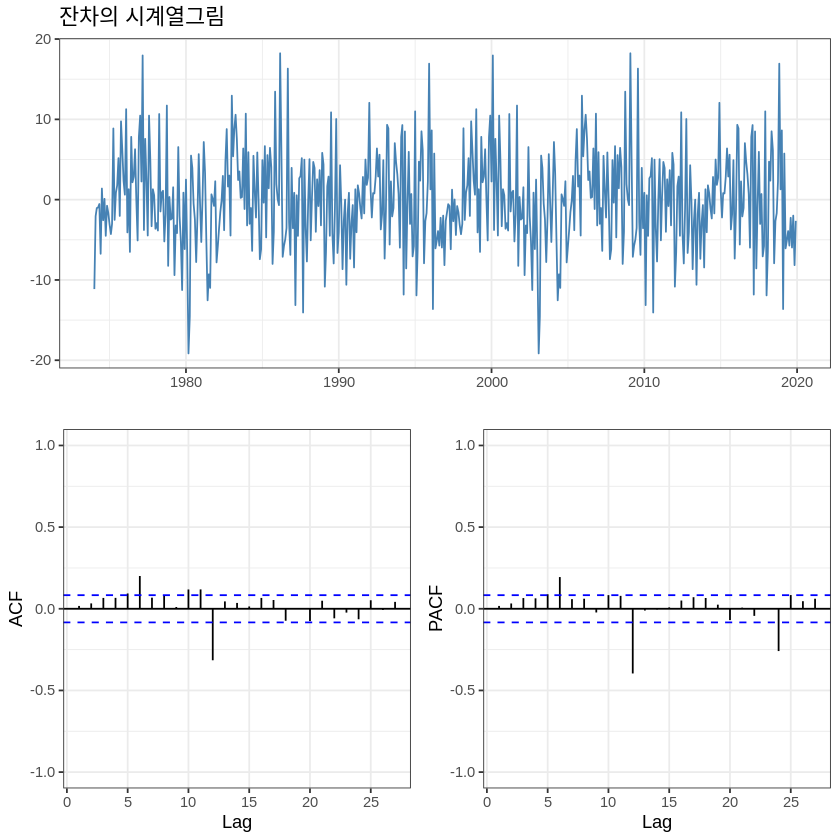

In [76]:
sdt[, res3 := as.numeric(resid(fit3))]

p3 <- ggplot(sdt, aes(t, res3)) + geom_line(col='steelblue') +
  xlab("")+ylab('')+ ggtitle('잔차의 시계열그림')+ theme_bw()

p1 <- ggAcf(sdt$res3) + theme_bw() + ylim(-1,1) +
  theme(plot.title = element_blank())

p2 <- ggPacf(sdt$res3) + theme_bw() +ylim(-1,1) +
  theme(plot.title = element_blank())

grid.arrange(p3, p1, p2, nrow = 2,
             layout_matrix = rbind(c(1,1), c(2,3)))

,lags,statistic,df,p-value
,6,22.20338,4,1.825755e-04
,12,32.62324,10,3.150648e-04
,18,39.96759,16,7.871188e-04
,24,61.09737,22,1.535508e-05



	Shapiro-Wilk normality test

data:  sdt$res
W = 0.99469, p-value = 0.053


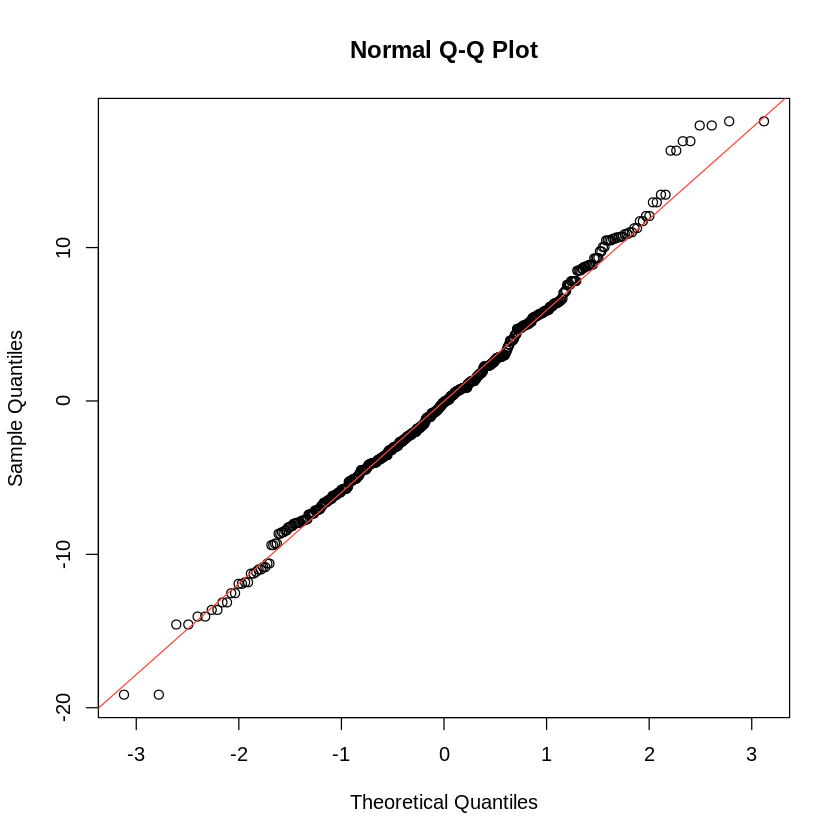

In [82]:
LjungBox(fit1, lags=seq(6,24,6))# 잔차의 포트맨토검정  

shapiro.test(sdt$res) 
qqnorm(sdt$res)
qqline(sdt$res, col = 2)

- 잔차들의 분포가 정규성 가정을 만족하는 것을 알 수 있었다.

##### (7) 다음 2년간의 값을 예측하여라 .

$pred
Time Series:
Start = 276 
End = 299 
Frequency = 1 
 [1] 42.54986 42.50700 42.46415 42.42129 42.37843 42.33557 42.29271 42.24985
 [9] 42.20699 42.16413 42.12127 42.07841 42.03555 41.99269 41.94983 41.90697
[17] 41.86411 41.82125 41.77839 41.73553 41.69267 41.64981 41.60695 41.56409

$se
Time Series:
Start = 276 
End = 299 
Frequency = 1 
 [1]  6.334150  9.610339 12.024798 14.029715 15.781954 17.358203 18.802776
 [8] 20.144020 21.401371 22.588843 23.716935 24.793752 25.825710 26.817988
[15] 27.774838 28.699804 29.595877 30.465605 31.311184 32.134520 32.937282
[22] 33.720938 34.486792 35.236004

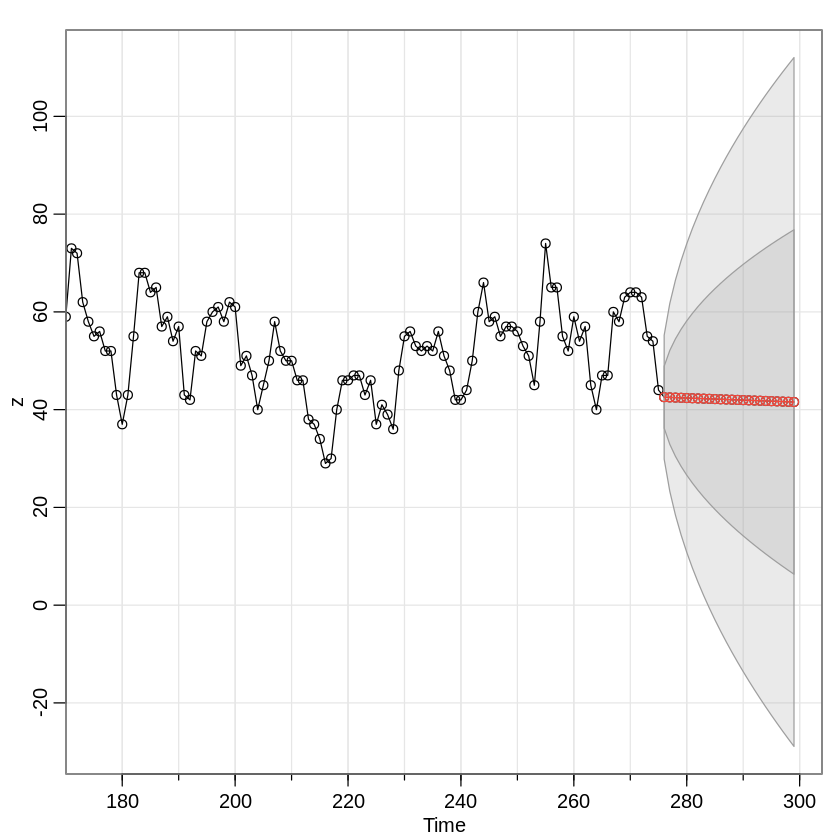

In [114]:
sarima.for(z, 24, 0,1,1)

$pred
Time Series:
Start = 553 
End = 576 
Frequency = 1 
 [1] -4.33089907 -0.08143428 -0.08143428 -0.08143428 -0.08143428 -0.08143428
 [7] -0.08143428 -0.08143428 -0.08143428 -0.08143428 -0.08143428 -0.08143428
[13] -0.08143428 -0.08143428 -0.08143428 -0.08143428 -0.08143428 -0.08143428
[19] -0.08143428 -0.08143428 -0.08143428 -0.08143428 -0.08143428 -0.08143428

$se
Time Series:
Start = 553 
End = 576 
Frequency = 1 
 [1] 7.607315 9.125226 9.125226 9.125226 9.125226 9.125226 9.125226 9.125226
 [9] 9.125226 9.125226 9.125226 9.125226 9.125226 9.125226 9.125226 9.125226
[17] 9.125226 9.125226 9.125226 9.125226 9.125226 9.125226 9.125226 9.125226

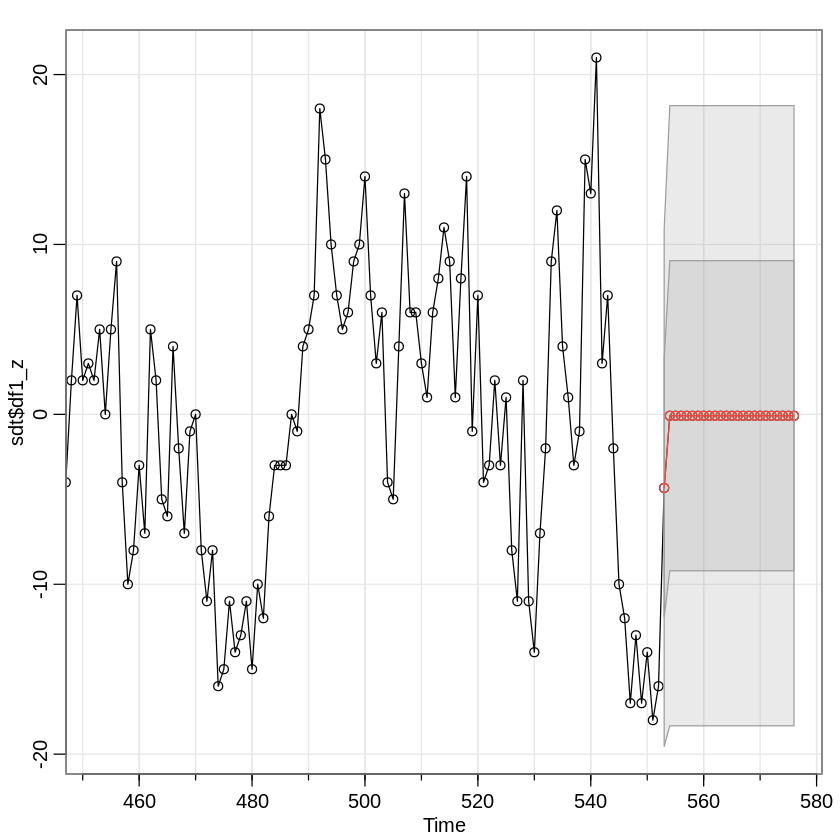

In [115]:
sarima.for(sdt$df1_z, 24, 0,0,1) # 차분했던 거 써줬을때